# Regression Model Training and Evaluation
This notebook explores data in the data/ directory, builds a regression model, and evaluates its performance.

In [4]:
import os
import gc
import csv
import scipy
import numerapi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor

In [ ]:
# Define target and prediction column names
TARGET_NAME = "target"
PREDICTION_NAME = "prediction"

## 1. Data Loading and Exploration

First, let's load the datasets from parquet files and examine their structure.

In [11]:
# Define paths to data files
data_dir = '../../data/'
train_path = os.path.join(data_dir, 'train.parquet')
validation_path = os.path.join(data_dir, 'validation.parquet')
live_path = os.path.join(data_dir, 'live.parquet')


training_data = pd.read_parquet(train_path)
validation_data = pd.read_parquet(validation_path)
live_data = pd.read_parquet(live_path)
print(f"Training data shape: {training_data.shape}")
print(f"Validation data shape: {validation_data.shape}")
print(f"Live data shape: {live_data.shape}")

Training data shape: (2746270, 2415)
Validation data shape: (3596488, 2415)
Live data shape: (6382, 2415)


In [12]:
# Examine the first few rows of training data
training_data.head()

,era,data_type,feature_shaded_hallucinatory_dactylology,feature_itinerant_hexahedral_photoengraver,feature_prudent_pileate_oven,feature_subalpine_apothegmatical_ajax,feature_pistachio_atypical_malison,feature_symmetrical_spongy_tricentenary,feature_ungrounded_transpontine_winder,feature_aseptic_eely_hemiplegia,...,target_teager2b_20,target_teager2b_60,target_tyler_20,target_tyler_60,target_victor_20,target_victor_60,target_waldo_20,target_waldo_60,target_xerxes_20,target_xerxes_60
id,,,,,,,,,,,,,,,,,,,,,
n0007b5abb0c3a25,0001,train,3,4,0,3,3,1,1,0,...,0.50,0.50,0.25,0.25,0.25,0.25,0.25,0.00,0.25,0.00
n003bba8a98662e4,0001,train,4,2,4,4,0,0,4,4,...,0.50,0.50,0.25,0.25,0.25,0.00,0.25,0.25,0.25,0.25
n003bee128c2fcfc,0001,train,2,4,0,3,0,3,2,4,...,1.00,1.00,1.00,0.75,0.75,0.75,0.75,1.00,0.75,0.75
n0048ac83aff7194,0001,train,2,1,3,0,3,0,3,3,...,0.25,0.25,0.25,0.25,0.50,0.25,0.25,0.25,0.25,0.25
n0055a2401ba6480,0001,train,4,1,4,1,0,4,0,4,...,0.50,0.50,0.25,0.50,0.25,0.50,0.25,0.50,0.25,0.50


In [21]:
TARGET_NAME = "target"  # Replace with actual target column name
PREDICTION_NAME = "prediction"  # Replace with actual prediction column name

In [16]:
# Get column names and identify feature columns
all_columns = list(training_data.columns)
print(f"Total columns: {len(all_columns)}")
print("\nSample column names:")
print(all_columns[:10])

# Try to identify feature columns (excluding target, era, etc.)
feature_columns = [col for col in all_columns if col not in [TARGET_NAME, PREDICTION_NAME, 'era', 'data_type']]
print(f"\nNumber of feature columns: {len(feature_columns)}")

Total columns: 2415

Sample column names:
['era', 'data_type', 'feature_shaded_hallucinatory_dactylology', 'feature_itinerant_hexahedral_photoengraver', 'feature_prudent_pileate_oven', 'feature_subalpine_apothegmatical_ajax', 'feature_pistachio_atypical_malison', 'feature_symmetrical_spongy_tricentenary', 'feature_ungrounded_transpontine_winder', 'feature_aseptic_eely_hemiplegia']

Number of feature columns: 2412


## 2. Feature Selection and Target Variable

Let's identify the features and target variable for our model.

Target column 'target' found in training data


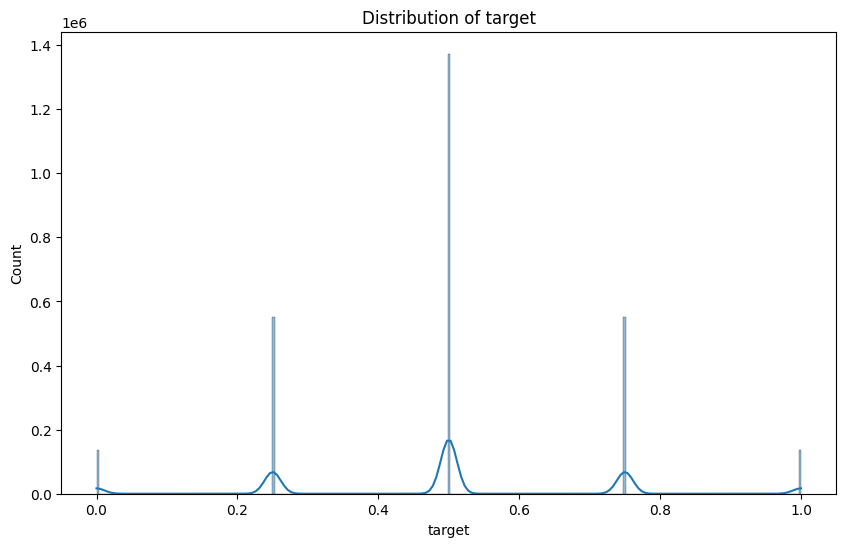

count    2.746270e+06
mean     5.000268e-01
std      2.231753e-01
min      0.000000e+00
25%      2.500000e-01
50%      5.000000e-01
75%      5.000000e-01
max      1.000000e+00
Name: target, dtype: float64


In [17]:
# Confirm we have the target column in our training data


if TARGET_NAME in training_data.columns:
    print(f"Target column '{TARGET_NAME}' found in training data")
    # Look at the target distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(training_data[TARGET_NAME], kde=True)
    plt.title(f"Distribution of {TARGET_NAME}")
    plt.show()
    
    # Basic statistics of target
    print(training_data[TARGET_NAME].describe())
else:
    print(f"Target column '{TARGET_NAME}' not found in training data")
    print("Available columns:", training_data.columns.tolist())

In [18]:
# Let's check for missing values in our data
missing_values_train = training_data.isnull().sum().sum()
missing_values_validation = validation_data.isnull().sum().sum()

print(f"Total missing values in training data: {missing_values_train}")
print(f"Total missing values in validation data: {missing_values_validation}")

# If we have many features, let's identify the most important ones
if len(feature_columns) > 20:
    # We'll use correlation with target for a simple feature selection
    corr_with_target = training_data[feature_columns].corrwith(training_data[TARGET_NAME]).abs().sort_values(ascending=False)
    top_features = corr_with_target.head(20).index.tolist()
    print("\nTop 20 features by correlation with target:")
    for i, (feature, corr) in enumerate(corr_with_target.head(20).items(), 1):
        print(f"{i}. {feature}: {corr:.4f}")
    
    # We'll use these top features for our model
    feature_names = top_features
else:
    feature_names = feature_columns

print(f"\nNumber of features selected for modeling: {len(feature_names)}")

Total missing values in training data: 48864
Total missing values in validation data: 2111227

Top 20 features by correlation with target:
1. target_cyrusd_20: 1.0000
2. target_xerxes_20: 0.9424
3. target_caroline_20: 0.9219
4. target_sam_20: 0.9116
5. target_ralph_20: 0.8949
6. target_echo_20: 0.8520
7. target_victor_20: 0.8382
8. target_waldo_20: 0.8331
9. target_delta_20: 0.8056
10. target_bravo_20: 0.8007
11. target_jeremy_20: 0.7910
12. target_charlie_20: 0.7677
13. target_alpha_20: 0.7652
14. target_claudia_20: 0.7451
15. target_teager2b_20: 0.7172
16. target_agnes_20: 0.7090
17. target_tyler_20: 0.7069
18. target_rowan_20: 0.7048
19. target_cyrusd_60: 0.4894
20. target_xerxes_60: 0.4862

Number of features selected for modeling: 20

Top 20 features by correlation with target:
1. target_cyrusd_20: 1.0000
2. target_xerxes_20: 0.9424
3. target_caroline_20: 0.9219
4. target_sam_20: 0.9116
5. target_ralph_20: 0.8949
6. target_echo_20: 0.8520
7. target_victor_20: 0.8382
8. target_wald

## 2.1 Handle Missing Values in Target Variable

Before training, we need to check for and handle NaN values in the target variable.

In [23]:
# Define target and prediction column names if not already defined
if 'TARGET_NAME' not in globals():
    TARGET_NAME = "target"
    
if 'PREDICTION_NAME' not in globals():
    PREDICTION_NAME = "prediction"
    
# Check for NaN values in target variables
train_nans = training_data[TARGET_NAME].isna().sum()
val_nans = validation_data[TARGET_NAME].isna().sum()

print(f"NaN values in training target: {train_nans} out of {len(training_data)} rows")
print(f"NaN values in validation target: {val_nans} out of {len(validation_data)} rows")

# Remove rows with NaN targets if any exist
if train_nans > 0:
    print(f"Removing {train_nans} rows with NaN targets from training data")
    training_data = training_data.dropna(subset=[TARGET_NAME])
    
if val_nans > 0:
    print(f"Removing {val_nans} rows with NaN targets from validation data")
    validation_data = validation_data.dropna(subset=[TARGET_NAME])

# Verify no NaN values remain
print(f"Remaining NaN values - Training: {training_data[TARGET_NAME].isna().sum()}, Validation: {validation_data[TARGET_NAME].isna().sum()}")

# Check for NaN values in features
train_feature_nans = training_data[feature_columns].isna().sum().sum()
val_feature_nans = validation_data[feature_columns].isna().sum().sum()

print(f"NaN values in training features: {train_feature_nans}")
print(f"NaN values in validation features: {val_feature_nans}")

# Fill NaN values in features with median
if train_feature_nans > 0 or val_feature_nans > 0:
    print("Filling NaN values in features with median values")
    for col in feature_columns:
        median = training_data[col].median()
        training_data[col] = training_data[col].fillna(median)
        validation_data[col] = validation_data[col].fillna(median)
        
    # Verify no NaN values remain in features
    print(f"Remaining NaN values in features - Training: {training_data[feature_columns].isna().sum().sum()}, Validation: {validation_data[feature_columns].isna().sum().sum()}")

NaN values in training target: 0 out of 2746270 rows
NaN values in validation target: 30919 out of 3596488 rows
Removing 30919 rows with NaN targets from validation data
Remaining NaN values - Training: 0, Validation: 0
Remaining NaN values - Training: 0, Validation: 0
NaN values in training features: 48864
NaN values in validation features: 967224
Filling NaN values in features with median values
NaN values in training features: 48864
NaN values in validation features: 967224
Filling NaN values in features with median values
Remaining NaN values in features - Training: 0, Validation: 0
Remaining NaN values in features - Training: 0, Validation: 0


## 3. Model Training

Now let's train our CatBoost regressor model.

In [24]:
# Define model parameters
model_filename = "gradient_model.cbm"
params = {
    'iterations': 1000,
    'learning_rate': 0.05,
    'depth': 6,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'random_seed': 42,
    'early_stopping_rounds': 50,
    'verbose': 100
}

# Explicitly use CPU to avoid GPU-related errors
print("Using CPU for training")

# Initialize and train the model
model = CatBoostRegressor(**params)

# Prepare data
X_train = training_data[feature_names].astype(np.float64)
y_train = training_data[TARGET_NAME].astype(np.float64)
X_val = validation_data[feature_names].astype(np.float64)
y_val = validation_data[TARGET_NAME].astype(np.float64)

# Extra verification for NaN values
assert np.isnan(y_train).sum() == 0, "NaN values found in training target"
assert np.isnan(y_val).sum() == 0, "NaN values found in validation target"

print("Starting model training...")
try:
    model.fit(
        X_train,
        y_train,
        eval_set=(X_val, y_val),
        plot=True
    )
    
    # Save the trained model
    model.save_model(model_filename)
    print(f"Model saved as {model_filename}")
except Exception as e:
    print(f"Error during training: {str(e)}")

Using CPU for training
Starting model training...
Starting model training...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.2120170	test: 0.2120764	best: 0.2120764 (0)	total: 144ms	remaining: 2m 23s
100:	learn: 0.0012576	test: 0.0012638	best: 0.0012638 (100)	total: 6.71s	remaining: 59.7s
100:	learn: 0.0012576	test: 0.0012638	best: 0.0012638 (100)	total: 6.71s	remaining: 59.7s
200:	learn: 0.0000414	test: 0.0001013	best: 0.0001013 (200)	total: 13.1s	remaining: 52.2s
200:	learn: 0.0000414	test: 0.0001013	best: 0.0001013 (200)	total: 13.1s	remaining: 52.2s
300:	learn: 0.0000281	test: 0.0000919	best: 0.0000919 (300)	total: 18.9s	remaining: 43.8s
300:	learn: 0.0000281	test: 0.0000919	best: 0.0000919 (300)	total: 18.9s	remaining: 43.8s
400:	learn: 0.0000217	test: 0.0000874	best: 0.0000874 (400)	total: 24.6s	remaining: 36.7s
400:	learn: 0.0000217	test: 0.0000874	best: 0.0000874 (400)	total: 24.6s	remaining: 36.7s
500:	learn: 0.0000177	test: 0.0000845	best: 0.0000845 (500)	total: 30.6s	remaining: 30.4s
500:	learn: 0.0000177	test: 0.0000845	best: 0.0000845 (500)	total: 30.6s	remaining: 30.4s
600:	learn: 0

## 4. Model Evaluation

Let's evaluate our model's performance on the validation dataset.

Model Performance on Validation Data:
Mean Squared Error (MSE): 0.000000
Root Mean Squared Error (RMSE): 0.000080
Mean Absolute Error (MAE): 0.000001
R² Score: 1.000000


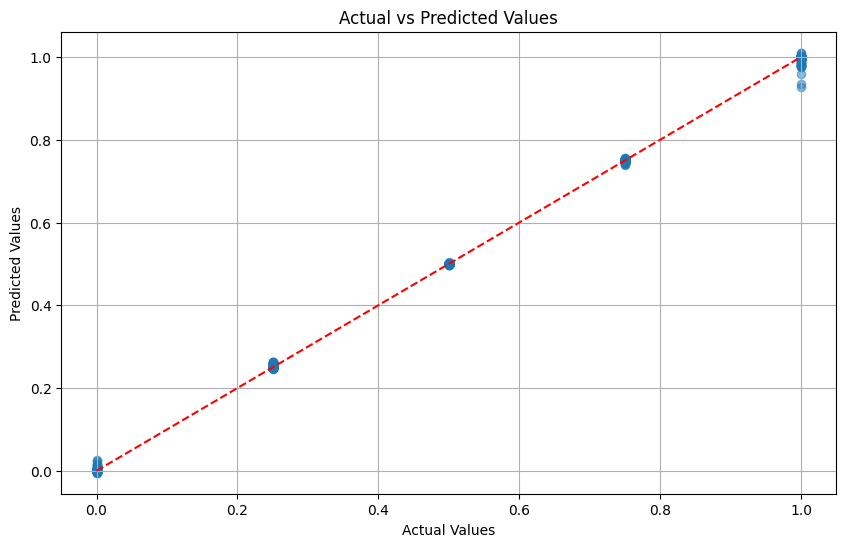

: 

In [25]:
# Generate predictions on validation data
val_predictions = model.predict(validation_data[feature_names].astype(np.float64))

# Calculate evaluation metrics
mse = mean_squared_error(validation_data[TARGET_NAME], val_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(validation_data[TARGET_NAME], val_predictions)
r2 = r2_score(validation_data[TARGET_NAME], val_predictions)

print("Model Performance on Validation Data:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R² Score: {r2:.6f}")

# Create a dataframe with actual and predicted values
results_df = pd.DataFrame({
    'Actual': validation_data[TARGET_NAME],
    'Predicted': val_predictions
})

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(results_df['Actual'], results_df['Predicted'], alpha=0.5)
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], 
         [results_df['Actual'].min(), results_df['Actual'].max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.grid(True)
plt.show()

# Plot prediction error distribution
results_df['Error'] = results_df['Actual'] - results_df['Predicted']
plt.figure(figsize=(10, 6))
sns.histplot(results_df['Error'], kde=True)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error')
plt.grid(True)
plt.show()

## 5. Feature Importance Analysis

Let's examine which features were most important for our model.

In [ ]:
# Get feature importance from the model
feature_importances = model.get_feature_importance()
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()

# Display the feature importance table
print("Top 20 Feature Importances:")
print(feature_importance_df.head(20).to_string(index=False))

## 6. Generate Predictions on Live Data

Let's use our trained model to make predictions on the live data.

In [ ]:
# Generate predictions for live data
live_predictions = model.predict(live_data[feature_names].astype(np.float64))

# Add predictions to the live dataframe
live_data[PREDICTION_NAME] = live_predictions

# Display the first few predictions
print("Live Data Predictions (first 5 rows):")
live_pred_sample = live_data[[PREDICTION_NAME]].head()
display(live_pred_sample)

# Save predictions to a CSV file
output_path = 'gradient_model_predictions.csv'
live_data[[PREDICTION_NAME]].to_csv(output_path, index=True)
print(f"\nPredictions saved to {output_path}")

In [ ]:
from catboost import CatBoostRegressor
Modelfile = "damodel.cbm"

# Define parameters without explicitly setting GPU
params = {
    'iterations': 1000,
    'learning_rate': 0.05,
    'depth': 6,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'random_seed': 42,
    'verbose': 100
}

model = CatBoostRegressor(**params)
model.fit(training_data[feature_names].astype(np.float64), 
         training_data[TARGET_NAME].astype(np.float64),
         eval_set=(validation_data[feature_names].astype(np.float64), 
                  validation_data[TARGET_NAME].astype(np.float64)))
model.save_model(Modelfile)